In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
import pydicom

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.head()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [3]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')

## EDA

In [4]:
all_xray_df['Patient ID'].count()

112120

In [5]:
all_xray_df['Patient ID'].nunique()

30805

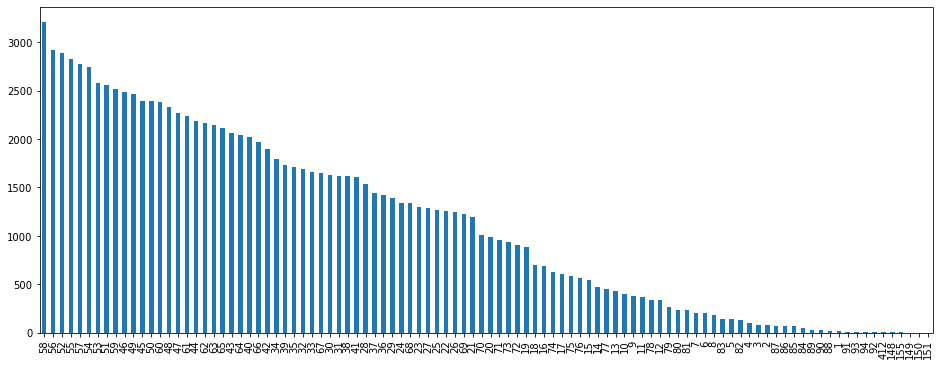

In [6]:
plt.figure(figsize=(16,6))
all_xray_df['Patient Age'].value_counts()[0:100].plot(kind='bar')

From above plot from Age distribution, there are some biased age(some are 150+) value incuded in the data. which are perfom as dirty data.

In [7]:
all_xray_df['Patient Age'].unique()

array([ 58,  81,  74,  75,  76,  77,  78,  79,  80,  82,  69,  70,  73,
        84,  61,  60,  62,  56,  57,  71,  66,  53,  47,  48,  49,  63,
        64,  52,  68,  59,  55,  72,  67,  46,  91,  92,  87,  65,  45,
        54,  50,  51,  44,  83,  33,  42,  25,  31,  94,  89,  90,  40,
        85,  30,  32,  34,  86,  37,  27,  29,  36,  38,  39,  43,  28,
        41,  35,  22,  23,  26,  21,  88,  24,  17,  18,  19,  20,  16,
        13,  14,  11,  12,  15,  93,   9,  10,   8,   6,   7,   4,   5,
         3,   2, 412,   1, 414, 148,  95, 150, 149, 152, 151, 411, 413,
       153, 154, 155])

M    63340
F    48780
Name: Patient Gender, dtype: int64

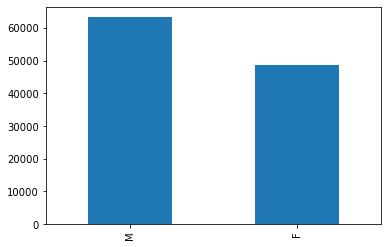

In [8]:
ax = all_xray_df['Patient Gender'].value_counts()
ax.plot(kind='bar')
ax

PA    67310
AP    44810
Name: View Position, dtype: int64

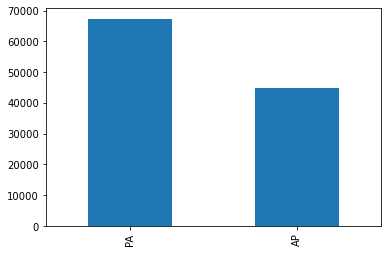

In [9]:
position = all_xray_df['View Position'].value_counts()
position.plot(kind='bar')
position

In [10]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

Pneumonia case: 1431.0


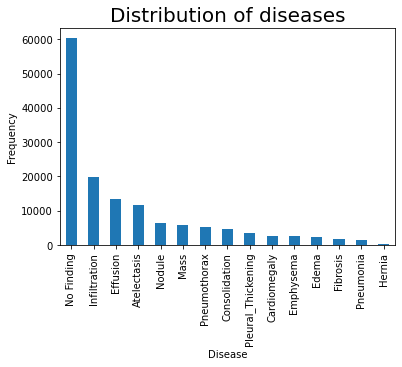

In [12]:
plt.figure()
all_xray_df[all_labels].sum().sort_values(ascending=False).plot(kind='bar')
plt.title("Distribution of diseases", fontsize=20)
plt.xlabel("Disease")
plt.ylabel("Frequency")
print("Pneumonia case:", all_xray_df["Pneumonia"].sum())

In [13]:
all_xray_df[all_labels].sum()/len(all_xray_df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

In [14]:
print(f"Pneumonia cases {all_xray_df['Pneumonia'].sum()} out of {all_xray_df.shape[0]}.")


Pneumonia cases 1431.0 out of 112120.


In [15]:
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


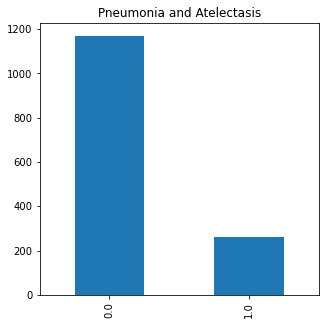

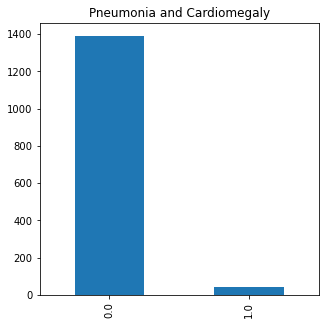

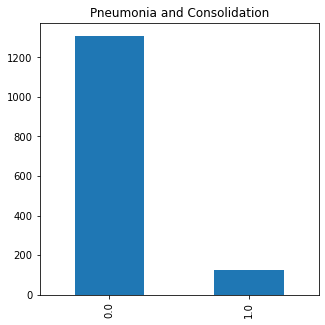

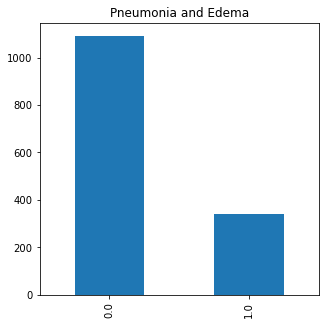

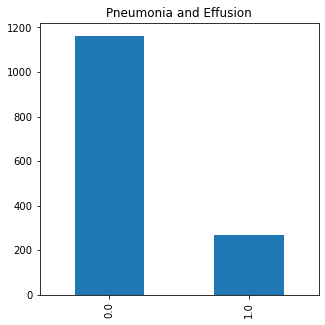

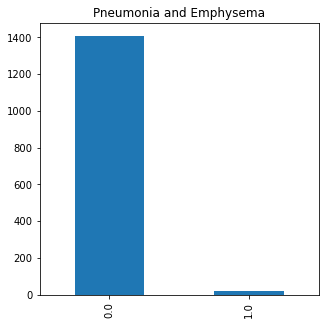

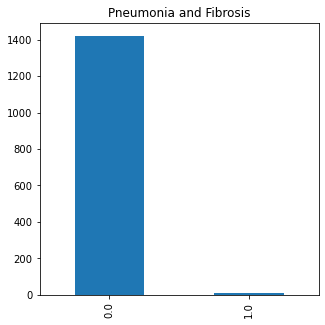

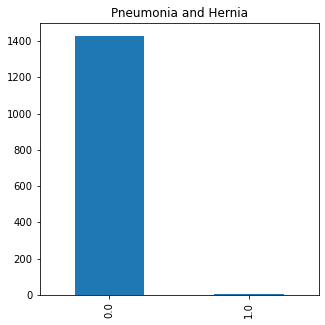

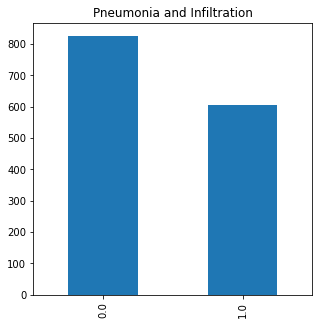

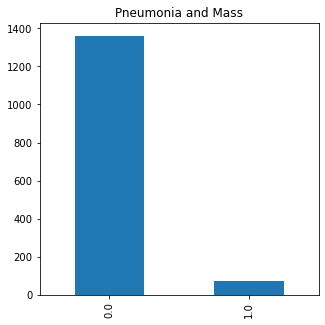

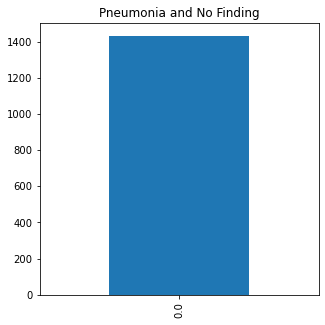

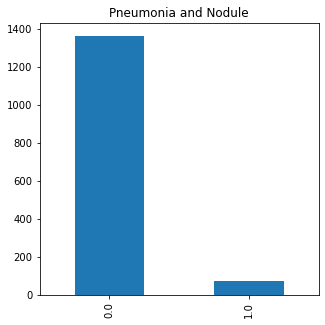

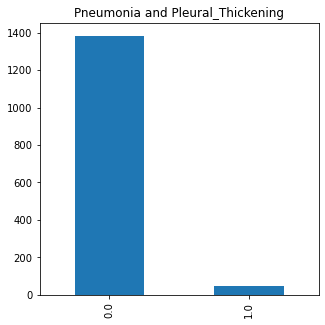

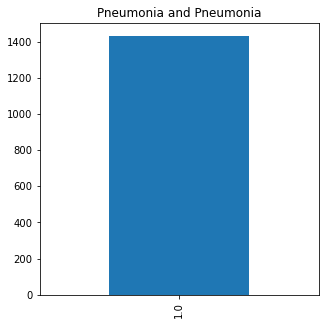

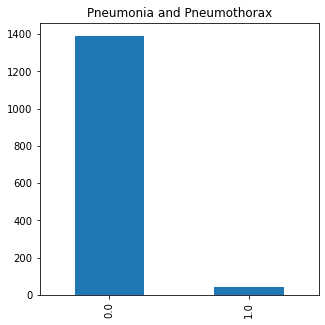

In [16]:
for label in all_labels:
    plt.figure(figsize=(5,5))
    plt.title('Pneumonia and '+label)
    all_xray_df[all_xray_df.Pneumonia==1][label].value_counts().plot(kind='bar')

Text(0.5, 1.0, 'Age distribution for pneumonia cases')

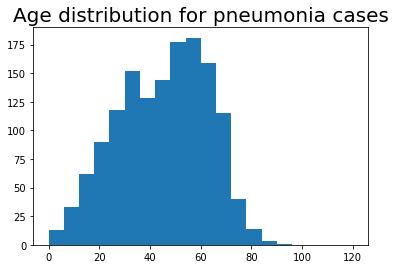

In [17]:
plt.figure()
plt.hist([all_xray_df[all_xray_df["Pneumonia"]==1]["Patient Age"].values], bins = 20, range=[0, 120])
plt.title('Age distribution for pneumonia cases', fontsize=20)

(array([  89.,  403.,  585., 1180., 1606., 1886., 1622., 2366., 2511.,
        2962., 2158., 1494.,  746.,  217.,   51.,   15.,    0.,    0.,
           0.,    0.]),
 array([  0.,   6.,  12.,  18.,  24.,  30.,  36.,  42.,  48.,  54.,  60.,
         66.,  72.,  78.,  84.,  90.,  96., 102., 108., 114., 120.]),
 <a list of 20 Patch objects>)

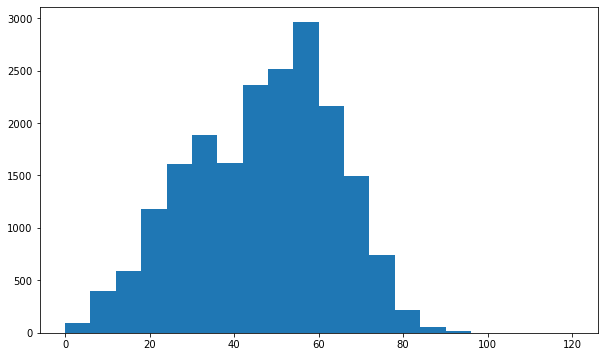

In [18]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Infiltration==1]['Patient Age'], bins = 20, range=[0, 120])

(array([   8.,  157.,  288.,  515.,  836., 1160.,  862., 1439., 1821.,
        2287., 1809., 1155.,  698.,  217.,   47.,   17.,    0.,    0.,
           0.,    0.]),
 array([  0.,   6.,  12.,  18.,  24.,  30.,  36.,  42.,  48.,  54.,  60.,
         66.,  72.,  78.,  84.,  90.,  96., 102., 108., 114., 120.]),
 <a list of 20 Patch objects>)

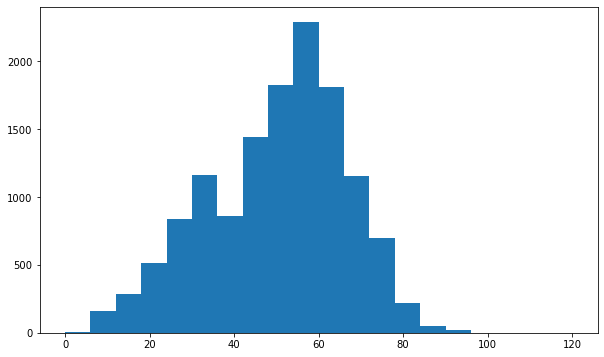

In [19]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Effusion==1]['Patient Age'], bins = 20, range=[0, 120])

In [20]:
all_xray_df.groupby(['Patient ID']).sum()
df = all_xray_df.groupby(['Patient ID'])[all_labels].sum()
df.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
Patient ID,,,,,,,,,,,,,,,
1,0.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,6.0,0.0,0.0,0.0,0.0


In [21]:
for label in all_labels:
    df.loc[df[label] > 0, label] = 1
df.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
Patient ID,,,,,,,,,,,,,,,
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [22]:
diseas_per_patient = df[all_labels].sum(axis=1)
diseas_per_patient.head(10)

Patient ID
1     3.0
2     1.0
3     2.0
4     2.0
5     3.0
6     1.0
7     1.0
8     3.0
9     1.0
10    1.0
dtype: float64

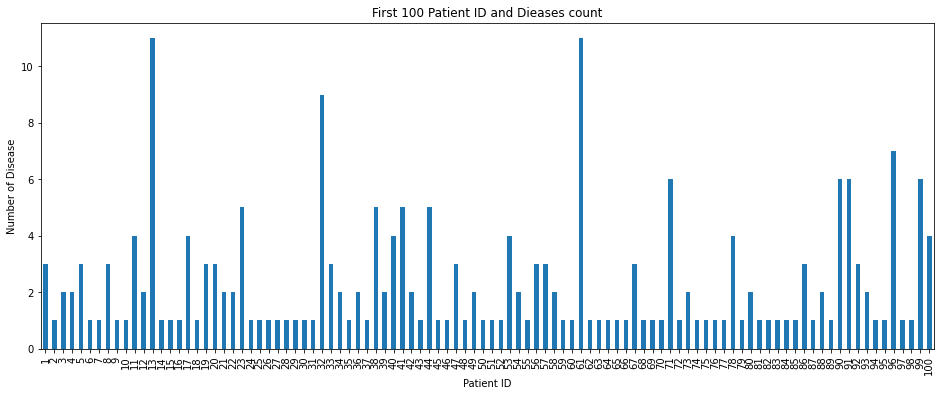

In [23]:
plt.figure(figsize=(16,6))
plt.title('First 100 Patient ID and Dieases count')
plt.ylabel('Number of Disease')
diseas_per_patient[:100].plot(kind='bar')

### Pixel-level assessments

In [24]:

all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(5)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
78249,00019196_000.png,No Finding,0,19196,59,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_009/images/00019196_000.png
1729,00000459_054.png,Infiltration,54,459,54,F,PA,2444,2924,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000459_054.png
80198,00019707_017.png,Pneumonia,17,19707,58,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/data/images_009/images/00019707_017.png
53208,00013436_000.png,Infiltration|Pleural_Thickening,0,13436,69,M,PA,2514,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,/data/images_006/images/00013436_000.png
34544,00009098_005.png,Mass|Nodule,5,9098,56,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,/data/images_004/images/00009098_005.png


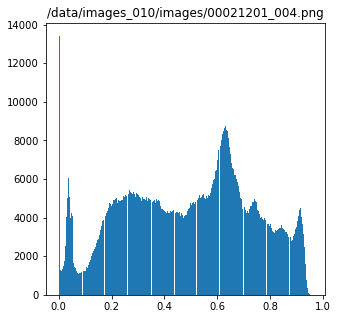

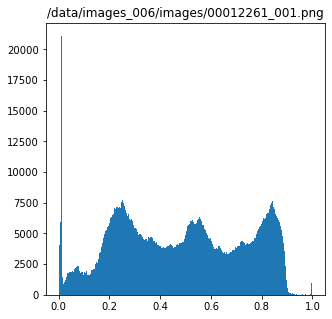

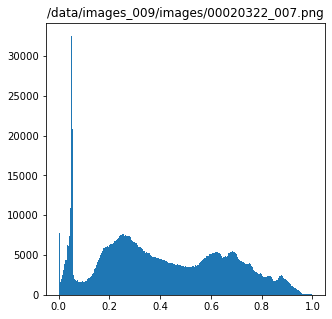

In [25]:
# Pixel distribution of Pneumonia

pnemonia_images = all_xray_df[all_xray_df.Pneumonia==1]['path'].sample(3)
for img_path in pnemonia_images:
    img = plt.imread(img_path)
    plt.figure(figsize=(5,5))
    plt.title(img_path)
    plt.hist(img.ravel(), bins = 256)

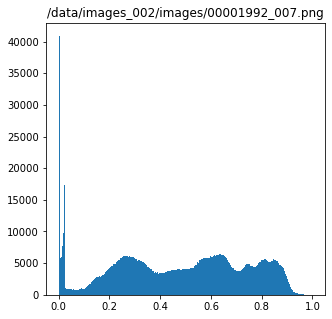

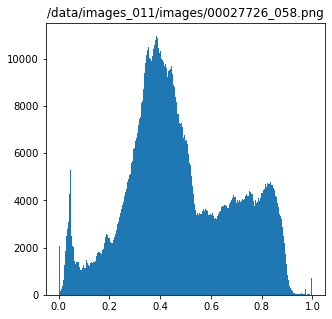

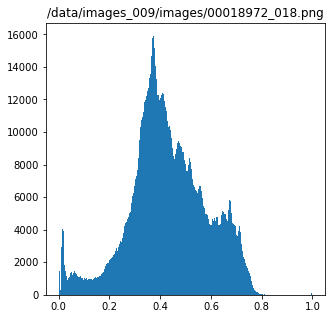

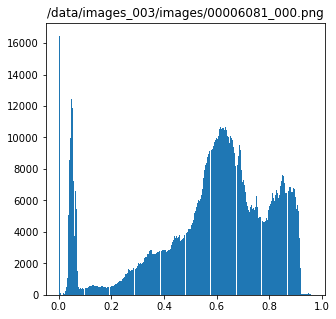

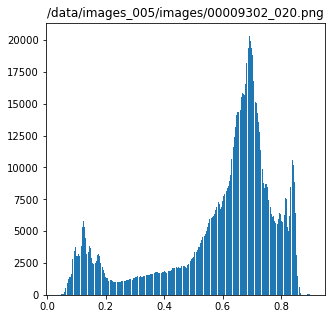

In [26]:
# Pixel distribution of Infiltration

Infiltration_images = all_xray_df[all_xray_df.Infiltration==1]['path'].sample(5)
for img_path in Infiltration_images:
    img = plt.imread(img_path)
    plt.figure(figsize=(5,5))
    plt.title(img_path)
    plt.hist(img.ravel(), bins = 256)
    


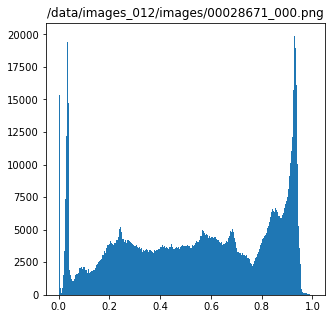

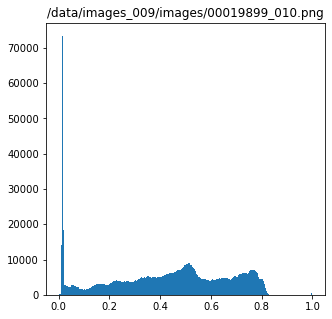

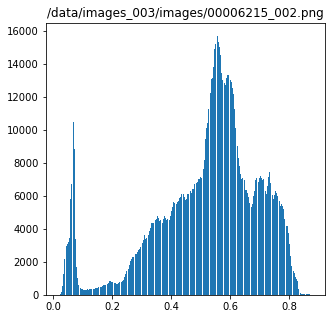

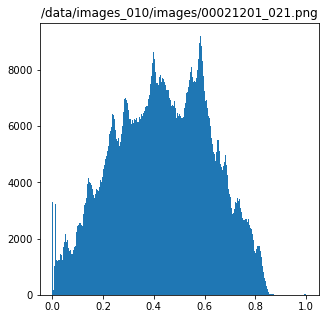

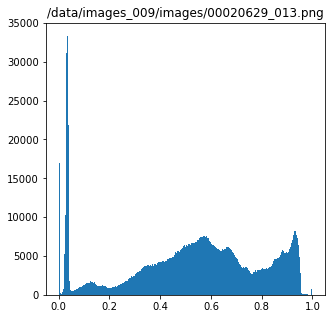

In [27]:
# Pixel distribution of Effusion

Effusion_images = all_xray_df[all_xray_df.Effusion==1]['path'].sample(5)
for img_path in Effusion_images:
    img = plt.imread(img_path)
    plt.figure(figsize=(5,5))
    plt.title(img_path)
    plt.hist(img.ravel(), bins = 256)

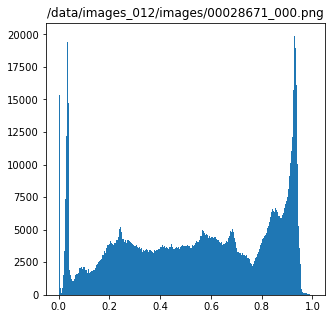

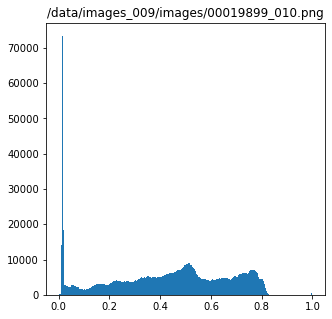

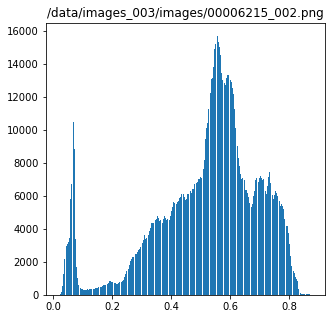

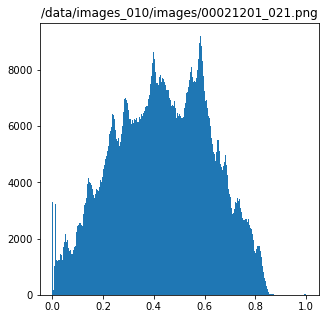

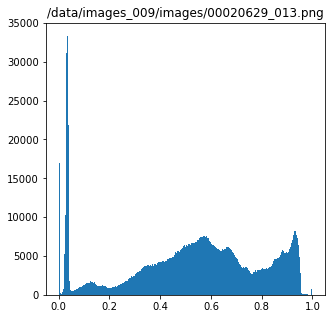

In [32]:
# Pixel distribution of Pneumonia-Effusion

Pneumonia_Effusion_images = all_xray_df[(all_xray_df.Pneumonia==1) & (all_xray_df.Effusion==1)]['path'].sample(5)
for img_path in Effusion_images:
    img = plt.imread(img_path)
    plt.figure(figsize=(5,5))
    plt.title(img_path)
    plt.hist(img.ravel(), bins = 256)

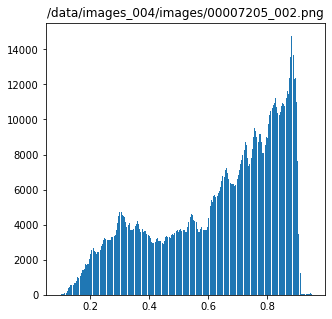

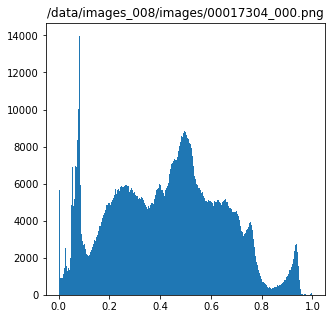

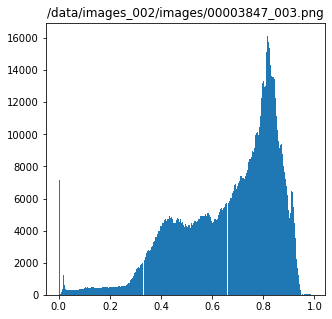

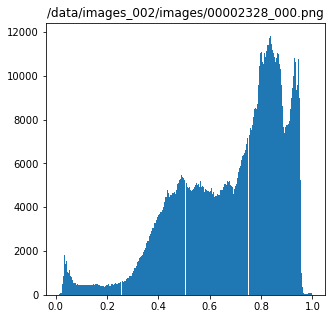

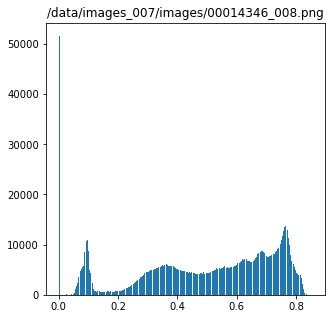

In [33]:
non_pnemonia_images = all_xray_df[all_xray_df.Pneumonia==0]['path'].sample(5)
for img_path in non_pnemonia_images:
    img = plt.imread(img_path)
    plt.figure(figsize=(5,5))
    plt.title(img_path)
    plt.hist(img.ravel(), bins = 256)

In [34]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

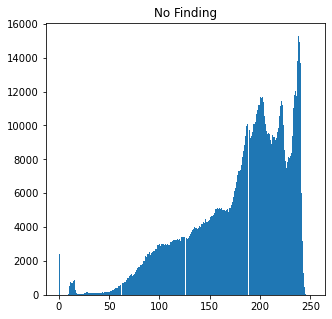

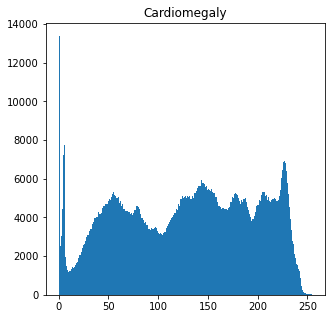

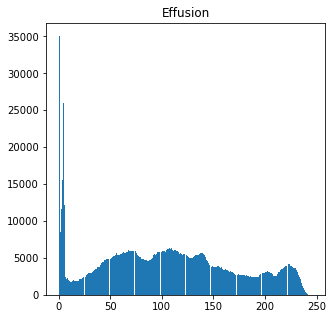

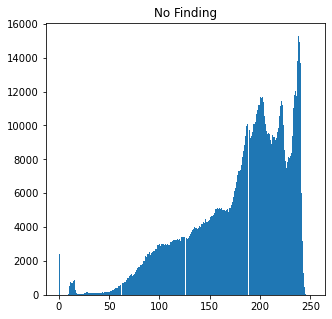

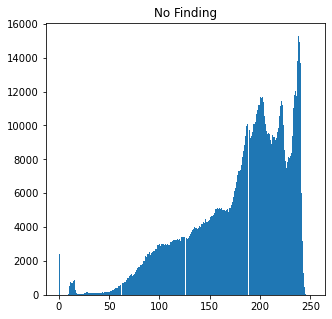

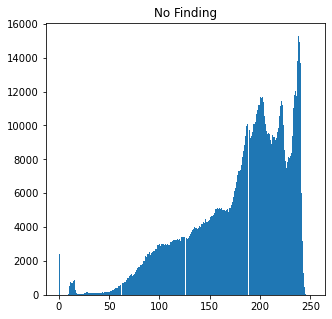

In [35]:
for i in test_dicoms:
    dcm = pydicom.dcmread(i)
    
    #plt.imshow(dcm.pixel_array,cmap='gray')
    plt.figure(figsize=(5,5))
    plt.title(dcm.StudyDescription)
    plt.hist(dcm.pixel_array.ravel(), bins = 256)

* Through Pixel_level assesment we can see that if there is a abnormal peak in between 0.1-0.7, there is chance of pneumonia. While in the case of non_pneumonia there is peak arround 0.8 and other than that there is nonrmal distribution.
* When Pneumonia occurs with other dieases(Effusion) their is abormal spikes in middle range most.

* First of all there is different size of images available so to train the model all images must have to be in same size.
* All the images have to be normalized and standardize so that variations in sensitivy can be reduced in specific range.
* There is biased value in Patient Age, so model cant be set to perticular age. But majority of the cases ranges between 20-65.